evaluates the results on baseline model - `CLIPLSTM`

In [4]:
import pandas as pd
df = pd.read_csv('/common/home/vk405/Projects/Crossmdl/nbs/csvlogs/clip_lstm/metrics.csv')

<AxesSubplot:>

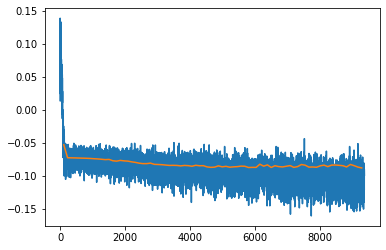

In [6]:
df['train_loss'].dropna().plot()
df['val_loss'].dropna().plot()

In [9]:
#pad your sequences

from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import LearningRateMonitor
import torch
import numpy as np
from PIL import Image
import os
from collections import defaultdict
import json
import joblib
from torch.utils.data import Dataset,DataLoader,random_split
from itertools import repeat
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
from numpy import linalg as LA
from argparse import Namespace
from numpy import genfromtxt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import clip


import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

logger = logging.getLogger(__name__)
wandb_logger = lambda dir, version: WandbLogger(
    name="wandb", save_dir=dir, version=version
)
csvlogger = lambda dir, version: CSVLogger(dir, name="csvlogs", version=version)
tblogger = lambda dir, version: TensorBoardLogger(dir, name="tblogs", version=version)

def get_loggers(dir,version,lis=["csv"]):
    lgrs = []
    if "wandb" in lis:
        lgrs.append(wandb_logger(dir, version))
    if "csv" in lis:
        lgrs.append(csvlogger(dir, version))
    if "tb" in lis:
        lgrs.append(tblogger(dir, version))
    return lgrs







def get_vid_ids(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'):
    # Returns vid_ids corresponding to the split: 'training'/'validation'
    
    vid_lis = []
    with open(annotns_file) as json_file:
        annotns = json.load(json_file)['database']
        for key in annotns:
            if annotns[key]['subset'] == split:
                vid_lis.append(key)
    return vid_lis


def get_split_files(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json',\
        data_dir = '/common/users/vk405/Youcook/'):
    total_ids = get_vid_ids(split,annotns_file)
    downloaded_ids = set([dir for dir in os.listdir(data_dir) if 'joblib' not in dir])
    vid_locs = []
    sents = {}
    segs = {}
    incomplete = []
    for id in total_ids:
        if id in downloaded_ids:
            vid_loc = data_dir+id + '/'
            if len(os.listdir(vid_loc))>=495:
                vid_locs.append(vid_loc)
                seg = joblib.load(data_dir+f'{id}global_segs.joblib')
                sent = joblib.load(data_dir+f'{id}global_sents.joblib')
                try:
                    sents[id] = sent[id]
                    segs[id] = seg[id]
                except:
                    print(f"{id} is no corresponding global sent/seg")
            else:
                #print(f"{id} has only imgs {len(os.listdir(vid_loc))}")
                incomplete.append(id)
    return vid_locs,segs,sents,incomplete 

import pathlib

FEAT_DIR = pathlib.Path('/common/users/vk405/CLIP_FEAT')
RAWFRAME_DIR = pathlib.Path('/common/users/vk405/Youcook/')

class Dset(Dataset):
    def __init__(self,data_dir,feat_dir,split='training'):
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.split = split
        self.vid_ids,self.sents = self.get_ids()
        self.labels = self.getlabels()
        self.sanitycheck()
        self.data = self.getdata()
        


    def sanitycheck(self):
        mis = []
        #import pdb;pdb.set_trace()
        for key in self.labels.keys():
            txt_loc = self.feat_dir/self.split/f'txt_{key}.joblib'
            txt = joblib.load(txt_loc)
            if len(self.labels[key]) == len(self.sents[key]) == len(txt):
                pass
            else:
                print(key)
                mis.append(key)
        print(f"segs are not matching:{mis}")
        for key in mis:
            self.vid_ids.remove(key)
        self.sents = None

        
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.load(self.data[idx])

    def getdata(self):
        data = []
        for id in self.vid_ids:
            segs = self.labels[id]
            #import pdb;pdb.set_trace()
            for i in range(len(segs)):
                data.append((id,i))
        return data

    def load(self,data):
        vid_id,ind = data
        vid_frames_loc = self.feat_dir/self.split/f'vid_{vid_id}.joblib'
        txt_loc = self.feat_dir/self.split/f'txt_{vid_id}.joblib'
        st,end = self.labels[vid_id][ind]
        vid = joblib.load(vid_frames_loc)
        try:
            txt = joblib.load(txt_loc)[ind]
        except:
            import pdb;pdb.set_trace()
        #normalize data
        #import pdb;pdb.set_trace()
        vid = vid/(LA.norm(vid,axis=-1)).reshape(500,1)
        txt = (txt/LA.norm(txt))
        #out = np.squeeze(vid@txt.reshape(512,1))
        #regression outputs
        return vid,txt,st/499,end/499
         

    def getlabels(self):
        label_dict = {}
        for vidid in self.vid_ids:
            vidloc = self.data_dir/vidid
            segs = self.extract_seg(vidloc)
            label_dict[vidid] = segs
        return label_dict
    
    def extract_seg(self,vid_loc):
        imgs = sorted(os.listdir(vid_loc),key=lambda x: int(x.split('_')[0]))
        segs = defaultdict(list)
        for img in imgs:
            ind,rem = int(img.split('_')[0]),img.split('_')[-1]
            
            if 'n.' not in rem:
                #print(ind,rem)
                seg_id = int(rem.split('.')[0])
                segs[seg_id].append(ind)
                #print(seg_id,ind)
        final_segs = []
        #import pdb;pdb.set_trace()
        segids = sorted(segs.keys())
        for segid in segids:
            final_segs.append((min(segs[segid]),max(segs[segid])))
        return final_segs
        
    def get_ids(self):
        annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'
        data_dir = '/common/users/vk405/Youcook/'
        vid_locs,_,sents,_ = get_split_files(self.split,annotns_file,data_dir)
        ids = [ele.split('/')[-2] for ele in vid_locs]
        files = set(os.listdir(self.feat_dir/self.split))
        finids = []
        missing = []
        for id in ids:
            if f'vid_{id}.joblib' in files:
                finids.append(id)
            else:missing.append(id)
        print(f"missing:{missing}")
        return finids,sents
class ClipLstm(pl.LightningModule):
    
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.vid_encoder,self.text_encoder,self.finlin = self.get_nets(**self.hparams.network_params)
        
    def get_nets(self,bidirectional = True,vid_lyrs = 2,vid_hidim=64,vid_fsz=64\
        ,txt_lyrs=2,txt_fsz=64,act='Relu'):
        vid_enc = []
        last_dim = 512
        
        self.lstm = nn.LSTM(last_dim,vid_hidim,\
        vid_lyrs,bidirectional=bidirectional,batch_first=True)
        vid_enc.append(self.lstm)
        if act == 'Relu':
            self.activation = nn.ReLU()
        vid_enc.append(self.activation)
        self.vidfinlyr = nn.Linear(vid_hidim,vid_fsz)
        vid_enc.append(self.vidfinlyr)
        self.txtlyr = nn.Linear(512,txt_fsz)
        txt_enc = nn.Sequential(self.txtlyr,self.activation)
        
        return vid_enc,txt_enc,nn.Linear(txt_fsz,2)
            



    def forward(self,vid,txt):
        # modeling end = st+diff(positive/sigmoid)
        #fixing for now
        #torch.squeeze(self.start(self.shared(input)))
        lstm,act,lin = self.vid_encoder
        hiddens, (final_h, final_c) = lstm(vid.float())
        vid_out = lin(act(torch.mean(final_h,dim=0)))
        txt_out = self.text_encoder(txt.float())
        preds = torch.sigmoid(self.finlin(vid_out+txt_out))
        st_p = preds[:,0]
        diff = preds[:,-1]
        fin_pred = torch.stack([st_p,st_p+diff],-1)
        return fin_pred

    def giou(self,p,g):
        x1_p,_ = torch.min(p,1)
        x2_p,_ = torch.max(p,1)

        x1_g,_ = torch.min(g,1)
        x2_g,_ = torch.max(g,1)

        x_1_i,_ =  torch.max(torch.stack([x1_g,x1_p],1),1)
        x_2_i,_ = torch.min(torch.stack([x2_g,x2_p],1),1)

        x_1_c,_ = torch.min(torch.stack([x1_p,x1_g],1),1)
        x_2_c,_ = torch.max(torch.stack([x2_p,x2_g],1),1)

        I = x_2_i - x_1_i
        U = (x2_p-x1_p) + (x2_g-x1_g) - I
        AC = x_2_c-x_1_c

        return (I/U) - ((AC-U)/AC),(I/U)


        
    def training_step(self,batch,batch_idx):

        vid,txt,st,end = batch
        loss_fn = nn.MSELoss()
        # forward
        lstm,act,lin = self.vid_encoder
        hiddens, (final_h, final_c) = lstm(vid.float())
        vid_out = lin(act(torch.mean(final_h,dim=0)))
        txt_out = self.text_encoder(txt.float())
        preds = torch.sigmoid(self.finlin(vid_out+txt_out))
        st_p = preds[:,0]
        diff = preds[:,-1]
        fin_preds = torch.stack([st_p,st_p+diff],-1)


        grounds = torch.stack([torch.squeeze(st),torch.squeeze(end)],1)
        giou,iou = self.giou(fin_preds,grounds)
        loss = torch.mean(-1*giou)
        #preds = self(vid,txt)
        #st_loss = loss_fn(preds[:,0].float(),torch.squeeze(st).float())
        #end_loss = loss_fn(preds[:,1].float(),torch.squeeze(end).float())
        #loss_end = nn.CrossEntropyLoss()
        #import pdb;pdb.set_trace()
        #st_l = loss_st(torch.squeeze(self.start(self.shared(input))).float(),st.float())
        #end_l = loss_st(torch.squeeze(self.end(self.shared(input))).float(),end.float())
        #loss = st_loss + end_loss
        self.log("train_loss",loss,on_step=True)
        self.log("train_iou",torch.mean(iou),on_step=True)
        return loss

    def validation_step(self,batch,batch_idx):


        vid,txt,st,end = batch
        loss_fn = nn.MSELoss()
        # forward
        lstm,act,lin = self.vid_encoder
        hiddens, (final_h, final_c) = lstm(vid.float())
        vid_out = lin(act(torch.mean(final_h,dim=0)))
        txt_out = self.text_encoder(txt.float())
        preds = torch.sigmoid(self.finlin(vid_out+txt_out))
        st_p = preds[:,0]
        diff = preds[:,-1]
        fin_preds = torch.stack([st_p,st_p+diff],-1)

        grounds = torch.stack([torch.squeeze(st),torch.squeeze(end)],1)
        giou,iou = self.giou(fin_preds,grounds)
        loss = torch.mean(-1*giou)
        #loss = torch.mean(-1*self.giou(preds,grounds))
        #preds = self(vid,txt)
        #st_loss = loss_fn(preds[:,0].float(),torch.squeeze(st).float())
        #end_loss = loss_fn(preds[:,1].float(),torch.squeeze(end).float())
        #loss_end = nn.CrossEntropyLoss()
        #import pdb;pdb.set_trace()
        #st_l = loss_st(torch.squeeze(self.start(self.shared(input))).float(),st.float())
        #end_l = loss_st(torch.squeeze(self.end(self.shared(input))).float(),end.float())
        #loss = st_loss + end_loss
        self.log("val_loss",loss,on_step=False,on_epoch=True)
        self.log("val_iou",torch.mean(iou),on_step=False,on_epoch=True)

        return loss
        
    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

        


from argparse import Namespace
FEAT_DIR = pathlib.Path('/common/users/vk405/CLIP_FEAT')
RAWFRAME_DIR = pathlib.Path('/common/users/vk405/Youcook/')
#early_stop
cfg = Namespace(
    version = 'clip_lstm',
    retrain = 'true',
    id = 0,
    FEAT_DIR = FEAT_DIR,
    RAWFRAME_DIR = RAWFRAME_DIR,
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/YouCookII/",
    trn_split = 0.8,
    mode = 'train',
    split = 'training',
    loggers = ["csv"],
    seed = 0,
    network_params = {'bidirectional':True,'vid_lyrs':2,\
        'vid_hidim':64,'vid_fsz':64\
        ,'txt_lyrs':2,'txt_fsz':64,'act':'Relu'},
    cbs = ["checkpoint"],
    trainer = {'log_every_n_steps': 1,
    'max_epochs': 150},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_loss"},
    early_stop = {"monitor":"val_loss","mode":"min","patience":5},
    lr = 1e-4

)




/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
d = Dset(cfg.RAWFRAME_DIR,cfg.FEAT_DIR)
tl = DataLoader(d,batch_size=64,shuffle=False,num_workers = 5)


missing:['ukfCQQpZ0k4', 'NK2xHVWojgY', 'mixdagZ-fwI']
cwsDQ7M5OTI
uf65nfh6X2U
segs are not matching:['cwsDQ7M5OTI', 'uf65nfh6X2U']


In [5]:
from pathlib import Path
net = ClipLstm(cfg)
PATH = Path(cfg.artifacts_loc)/'ckpts'/cfg.version
ckpt = os.listdir(PATH)[0]
print(f'{ckpt}')
new_model = net.load_from_checkpoint(checkpoint_path=str(PATH/ckpt))

epoch=73-train_loss=-0.13.ckpt


In [6]:
new_model

ClipLstm(
  (lstm): LSTM(512, 64, num_layers=2, batch_first=True, bidirectional=True)
  (activation): ReLU()
  (vidfinlyr): Linear(in_features=64, out_features=64, bias=True)
  (txtlyr): Linear(in_features=512, out_features=64, bias=True)
  (text_encoder): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
  )
  (finlin): Linear(in_features=64, out_features=2, bias=True)
)

In [7]:
from tqdm import tqdm
def intersec_union(dl,model):
    orig = []
    pred = []
    model.eval()
    for batch in tqdm(dl):
        vid,txt,st,end = batch
        preds = model(vid,txt)
        orig.append(torch.stack([st,end],axis=-1))
        pred.append(preds)
    return torch.concat(orig,axis=0),torch.concat(pred,axis=0)
        
        



In [8]:
o,p = intersec_union(tl,new_model)

100%|██████████| 144/144 [01:31<00:00,  1.57it/s]


In [20]:
def giou(p,g):
    x1_p,_ = torch.min(p,1)
    x2_p,_ = torch.max(p,1)

    x1_g,_ = torch.min(g,1)
    x2_g,_ = torch.max(g,1)

    x_1_i,_ =  torch.max(torch.stack([x1_g,x1_p],1),1)
    x_2_i,_ = torch.min(torch.stack([x2_g,x2_p],1),1)

    x_1_c,_ = torch.min(torch.stack([x1_p,x1_g],1),1)
    x_2_c,_ = torch.max(torch.stack([x2_p,x2_g],1),1)

    I = x_2_i - x_1_i
    U = (x2_p-x1_p) + (x2_g-x1_g) - I
    #AC = x_2_c-x_1_c

    return (I/U)

In [10]:
out = giou(p,o)

In [35]:
torch.mean(out).detach().numpy()*100

array(14.2388)

In [2]:
# checking baseline-1 

import pandas as pd

df = pd.read_csv('/common/home/vk405/Projects/Crossmdl/nbs/csvlogs/clip/metrics.csv')

In [25]:
# get the corresponding dset

import pathlib

FEAT_DIR = pathlib.Path('/common/users/vk405/CLIP_FEAT')
RAWFRAME_DIR = pathlib.Path('/common/users/vk405/Youcook/')

class Dset(Dataset):
    def __init__(self,data_dir,feat_dir,split):
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.split = split
        self.vid_ids,self.sents = self.get_ids()
        self.labels = self.getlabels()
        self.sanitycheck()
        self.data = self.getdata()
        


    def sanitycheck(self):
        mis = []
        #import pdb;pdb.set_trace()
        for key in self.labels.keys():
            txt_loc = self.feat_dir/self.split/f'txt_{key}.joblib'
            txt = joblib.load(txt_loc)
            if len(self.labels[key]) == len(self.sents[key]) == len(txt):
                pass
            else:
                print(key)
                mis.append(key)
        print(f"segs are not matching:{mis}")
        for key in mis:
            self.vid_ids.remove(key)
        self.sents = None

        
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.load(self.data[idx])

    def getdata(self):
        data = []
        for id in self.vid_ids:
            segs = self.labels[id]
            #import pdb;pdb.set_trace()
            for i in range(len(segs)):
                data.append((id,i))
        return data

    def load(self,data):
        vid_id,ind = data
        vid_frames_loc = self.feat_dir/self.split/f'vid_{vid_id}.joblib'
        txt_loc = self.feat_dir/self.split/f'txt_{vid_id}.joblib'
        st,end = self.labels[vid_id][ind]
        vid = joblib.load(vid_frames_loc)
        try:
            txt = joblib.load(txt_loc)[ind]
        except:
            import pdb;pdb.set_trace()
        #normalize data
        #import pdb;pdb.set_trace()
        vid = vid/(LA.norm(vid,axis=-1)).reshape(500,1)
        txt = (txt/LA.norm(txt))
        out = np.squeeze(vid@txt.reshape(512,1))
        #regression outputs
        return out,st/499,end/499
         

    def getlabels(self):
        label_dict = {}
        for vidid in self.vid_ids:
            vidloc = self.data_dir/vidid
            segs = self.extract_seg(vidloc)
            label_dict[vidid] = segs
        return label_dict
    
    def extract_seg(self,vid_loc):
        imgs = sorted(os.listdir(vid_loc),key=lambda x: int(x.split('_')[0]))
        segs = defaultdict(list)
        for img in imgs:
            ind,rem = int(img.split('_')[0]),img.split('_')[-1]
            
            if 'n.' not in rem:
                #print(ind,rem)
                seg_id = int(rem.split('.')[0])
                segs[seg_id].append(ind)
                #print(seg_id,ind)
        final_segs = []
        #import pdb;pdb.set_trace()
        segids = sorted(segs.keys())
        for segid in segids:
            final_segs.append((min(segs[segid]),max(segs[segid])))
        return final_segs
        
    def get_ids(self):
        annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'
        data_dir = '/common/users/vk405/Youcook/'
        vid_locs,_,sents,_ = get_split_files(self.split,annotns_file,data_dir)
        ids = [ele.split('/')[-2] for ele in vid_locs]
        files = set(os.listdir(self.feat_dir/self.split))
        finids = []
        missing = []
        for id in ids:
            if f'vid_{id}.joblib' in files:
                finids.append(id)
            else:missing.append(id)
        print(f"missing:{missing}")
        return finids,sents

        

In [26]:
d = Dset(RAWFRAME_DIR,FEAT_DIR,'validation')
tl = DataLoader(d,batch_size=64,shuffle=False)

missing:[]
95WMX64RIBc
segs are not matching:['95WMX64RIBc']


In [12]:
#model 

class BaselineModel(pl.LightningModule):
    
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.shared = nn.Sequential(nn.Linear(500,250),nn.ReLU(),nn.Linear(250,125),nn.ReLU(),nn.Linear(125,2),nn.Sigmoid())
        
    def forward(self,x):
        #fixing for now
        #torch.squeeze(self.start(self.shared(input)))
        return self.shared(x)

    def giou(self,p,g):
        x1_p,_ = torch.min(p,1)
        x2_p,_ = torch.max(p,1)

        x1_g,_ = torch.min(g,1)
        x2_g,_ = torch.max(g,1)

        x_1_i,_ =  torch.max(torch.stack([x1_g,x1_p],1),1)
        x_2_i,_ = torch.min(torch.stack([x2_g,x2_p],1),1)

        x_1_c,_ = torch.min(torch.stack([x1_p,x1_g],1),1)
        x_2_c,_ = torch.max(torch.stack([x2_p,x2_g],1),1)

        I = x_2_i - x_1_i
        U = (x2_p-x1_p) + (x2_g-x1_g) - I
        AC = x_2_c-x_1_c

        return (I/U) - ((AC-U)/AC),(I/U)
            

    def training_step(self,batch,batch_idx):

        input,st,end = batch
        preds = self(input)
        st_p = preds[:,0]
        diff = preds[:,-1]
        fin_pred = torch.stack([st_p,st_p+diff],-1)
        grounds = torch.stack([torch.squeeze(st),torch.squeeze(end)],1)
        giou,iou = self.giou(fin_pred,grounds)
        loss = torch.mean(-1*giou)

        self.log("train_loss",loss,on_step=True)
        self.log("train_iou",torch.mean(iou),on_step=True)
        return loss
        

    def validation_step(self,batch,batch_idx):

        input,st,end = batch
        preds = self(input)
        st_p = preds[:,0]
        diff = preds[:,-1]
        fin_pred = torch.stack([st_p,st_p+diff],-1)
        grounds = torch.stack([torch.squeeze(st),torch.squeeze(end)],1)
        giou,iou = self.giou(fin_pred,grounds)
        loss = torch.mean(-1*giou)

        self.log("val_loss",loss,on_step=True)
        self.log("val_iou",torch.mean(iou),on_step=True)
        return loss
        
    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

        

In [16]:
from argparse import Namespace
import pathlib
from pathlib import Path
FEAT_DIR = pathlib.Path('/common/users/vk405/CLIP_FEAT')
RAWFRAME_DIR = pathlib.Path('/common/users/vk405/Youcook/')

cfg = Namespace(
    version = 'clip',
    id = 0,
    FEAT_DIR = FEAT_DIR,
    RAWFRAME_DIR = RAWFRAME_DIR,
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/YouCookII/",
    trn_split = 0.8,
    mode = 'train',
    split = 'training',
    loggers = ["csv"],
    seed = 0,
    cbs = ["checkpoint","early_stop"],
    trainer = {'log_every_n_steps': 1,
    'max_epochs': 100},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_loss"},
    early_stop = {"monitor":"val_loss","mode":"min","patience":5},
    lr = 1e-4

)


net = BaselineModel(cfg)
PATH = Path(cfg.artifacts_loc)/'ckpts'/cfg.version
ckpt = os.listdir(PATH)[1]
print(f'{ckpt}')
new_model = net.load_from_checkpoint(checkpoint_path=str(PATH/ckpt))

epoch=65-train_loss=-0.09.ckpt


In [27]:
from tqdm import tqdm
def intersec_union(dl,model):
    orig = []
    pred = []
    model.eval()
    for batch in tqdm(dl):
        sim,st,end = batch
        preds = model(sim)
        st_p = preds[:,0]
        diff = preds[:,-1]
        fin_pred = torch.stack([st_p,st_p+diff],-1)
        orig.append(torch.stack([st,end],axis=-1))
        pred.append(fin_pred)
    return torch.concat(orig,axis=0),torch.concat(pred,axis=0)

In [28]:
o,p = intersec_union(tl,new_model)

100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


In [29]:
out = giou(p,o)

In [30]:
torch.mean(out)*100

tensor(9.2427, dtype=torch.float64, grad_fn=<MulBackward0>)